In [1]:
import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset, random_split

# Summary-like from Tensorflow
from torchsummary import summary

# Import Numpy
import numpy as np
# Plot Import
import matplotlib.pyplot as plt
# For timer
import time
# Import OS
import os
# import local libs
import ecg_tools_lite as et

from statistics import mean

# WFDB
import wfdb

if not os.path.exists('./mlp_img'):
    os.mkdir('./mlp_img')

In [2]:
device = torch.device( 'cuda' if torch.cuda.is_available() else 'cpu')

print("Device:", device, time.localtime().tm_mon, "/", time.localtime().tm_mday, "/", time.localtime().tm_year)
device

Device: cuda 12 / 1 / 2020


device(type='cuda')

In [3]:
# =============== LOAD ECG DATA ===============
# Load numpy version datasets
# ecg_clean = et.load_ecg_file('all_chunks_fs1024_e24.npy')
# ecg_noisy = et.load_ecg_file('all_chunks_fs1024_e06.npy')
ecg_modded_06, ecg_untouched_06 = et.get_ecg_with_split('118e06', samp_freq=1024, norm_type='chunks')
ecg_modded_24, ecg_untouched_24 = et.get_ecg_with_split('118e24', samp_freq=1024, norm_type='chunks')
# Load datasets to CUDA
ecg_noisy = torch.from_numpy(ecg_modded_06).double() #.to(device)
ecg_clean = torch.from_numpy(ecg_untouched_06).double() #.to(device)

# Create train and validation datasets
train_size = int( (ecg_clean.shape[0])*.80 ) # Get 80%
val_size = int( (ecg_clean.shape[0])*.20 ) # Get 20%

# Use this for checking
total_size = train_size + val_size
if total_size < ecg_noisy.shape[0]:
    train_size = train_size + (ecg_noisy.shape[0] - total_size)

# Split datasets into train and validation
# ==== Use this if splitting the actual data set rather than index only
# train_dataset, val_dataset = random_split( ecg_noisy, (train_size, val_size) )  

# Create a data loader for both datasets
train_loader = DataLoader( train_dataset, shuffle=True, batch_size=1)
val_loader = DataLoader( val_dataset, shuffle=True, batch_size=1)
# Preview the shape of the train_loader
print( f"When train_loader is called, the entire shape is: {len(train_loader)}, 1024, 1" )
print( f"When val_loader is called, the entire shape is: {len(val_loader)}, 1024, 1" )
print( f"Total size: {total_size} = {train_size} + {val_size}" )

When train_loader is called, the entire shape is: 101, 1024, 1
When val_loader is called, the entire shape is: 25, 1024, 1
Total size: 125 = 101 + 25


In [4]:
# Well instead of having to randomize the data itself, why not the numbers used to index
index_set = np.arange(0, total_size+1)
train_indexset, val_indexset = random_split( index_set, (train_size, val_size))
traindex_loader = DataLoader( train_indexset, shuffle=True, batch_size=1 )
valdex_loader = DataLoader( val_indexset, shuffle=True, batch_size=1 )

0
Shape: torch.Size([1, 1024, 1])


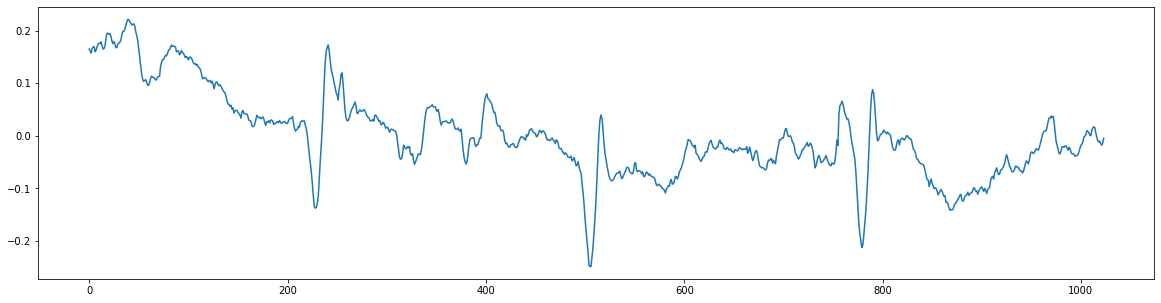

In [5]:
# If we look at how DataLoader works, we will get a random data everytime it is called thus, 
# running the lines below will result into a different ECG data
for i, data in enumerate( train_loader ):
    print( i )
    if i == 0:
        print(f'Shape: {data.shape}')
        x = data.cpu().numpy()
        plt.figure( figsize=(20,5) )
        plt.plot( x[0][:] )
        break

0 contains 50


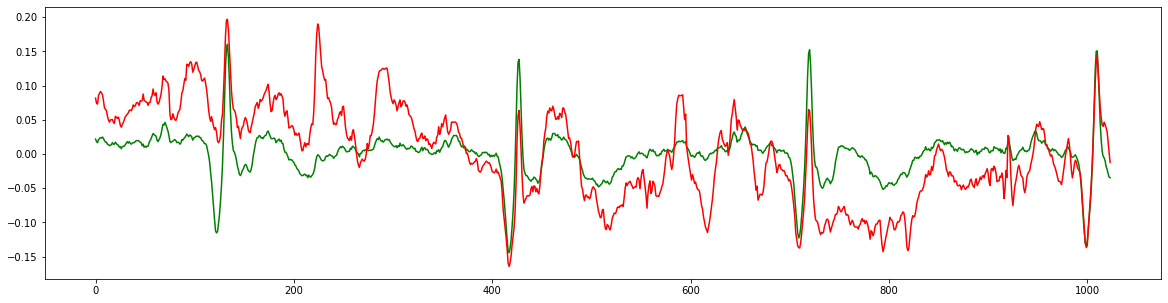

In [6]:
# Below when ran, will use random indexes for loading the data

for i, data in enumerate( traindex_loader ):
    print( f'{i} contains {data.cpu().numpy()[0]}' )
    if i == 0:
        x = data.cpu().numpy()[0]
        samp_clean = ecg_noisy_24[x]
        samp_noisy = ecg_noisy_06[x]
        plt.figure( figsize=(20,5) )
        plt.plot( samp_clean, c='green' )
        plt.plot( samp_noisy, c='red' )
        break

In [16]:
# Example of how to create a Pytorch tensor from Numpy (with cuda support)
ecg_clean_tensor = torch.from_numpy(ecg_noisy_24).cuda()
ecg_noisy_tensor = torch.from_numpy(ecg_noisy_06).cuda()
# When printed, device will be set to cuda
print( ecg_clean_tensor.shape )

torch.Size([126, 1024, 1])


In [28]:
kernel_size = 16
padding_size= int( kernel_size/2 ) # If odd, add -1

class ae_sampler(nn.Module):
    def __init__(self):
        super(ae_sampler, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv1d(1024, 40, kernel_size, stride=2, padding=padding_size),
            nn.ELU(True),
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(40, 1024, kernel_size, stride=2),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)

        return x

In [29]:
# Run this part to test if your data is properly shaped with the model
model = ae_sampler().cuda()
model.double() # Since data is using double, force model to use double rather than floatType
# Data below is double dtype
temp_data = ecg_noisy_tensor[3]
print( f'Original shape: {temp_data.shape}')
# Change the shape/view of the data (useful later on)
temp_data = temp_data.view( 1, temp_data.shape[0], temp_data.shape[1])
print( f'Modified shape: {temp_data.shape}')
# Check if model will accept the data's new shape
model( temp_data )

Original shape: torch.Size([1024, 1])
Modified shape: torch.Size([1, 1024, 1])


tensor([[[-0.0040, -0.0039, -0.0034,  ..., -0.0040, -0.0033, -0.0036],
         [ 0.0075,  0.0077,  0.0077,  ...,  0.0080,  0.0081,  0.0075],
         [ 0.0052,  0.0056,  0.0053,  ...,  0.0058,  0.0051,  0.0052],
         ...,
         [ 0.0017,  0.0014,  0.0013,  ...,  0.0019,  0.0015,  0.0015],
         [ 0.0083,  0.0080,  0.0079,  ...,  0.0079,  0.0076,  0.0079],
         [-0.0073, -0.0069, -0.0067,  ..., -0.0070, -0.0070, -0.0073]]],
       device='cuda:0', dtype=torch.float64, grad_fn=<SqueezeBackward1>)

In [30]:
def train_model(model, trainloader, epochs):
    elapsed_start = time.time()
    train_loss = []
    criterion = nn.MSELoss().cuda()
    optimizer = torch.optim.Adam( model.parameters(), lr=1e-3 )
    
    for epoch in range(epochs):
        # Running loss computed at the end
        running_loss = 0.0        
        # start timer
        epoch_start = time.time()
        # Loop through the entire dataset
        for i, data_index in enumerate(traindex_loader):
            # Load the noise sample
            index = data_index.numpy()[0]
            noise_samp = ecg_noisy_tensor[index]
            clean_samp = ecg_clean_tensor[index]
            noise_samp = noise_samp.view( 1, noise_samp.shape[0], noise_samp.shape[1])
            clean_samp = clean_samp.view( 1, clean_samp.shape[0], clean_samp.shape[1])
            # Convert x_samps to tensors and in cuda
            optimizer.zero_grad()
            # one_sig = noise_sig
            # one_sig = noise_sig.view( noise_sig.shape[1], noise_sig.shape[0], 1)
            
            x_prime = model( noise_samp )
            
            loss = criterion( x_prime, clean_samp) # or loss function
            
            # Backpropagation
            loss.backward()
            
            optimizer.step()
            running_loss += loss.item()
        
            loss = running_loss / len(trainloader)
        
            train_loss.append(loss)

        # ===== Epoch timer =====
        epoch_end = time.time()
        time_total = epoch_end - epoch_start
        print( f"Epoch {epoch+1} of 2 || time: {time_total:.2f} || loss = {loss}")
        # ===== Total training elapsed time =====
    elapsed_end = time.time()
    elapsed_total = elapsed_end-elapsed_start
    elapsed_mins = int(elapsed_total/60)
    elapsed_secs = int(elapsed_total - (60 * elapsed_mins))
    print(f'Elapsed time: {elapsed_total:.2f}, (in mins: {elapsed_mins}:{elapsed_secs})')

    return train_loss

In [31]:
model = ae_sampler().cuda()
model.double()
losses = train_model( model, traindex_loader, 2)
# train_model( ae_sampler, noiseloader, 1)

Epoch 1 of 2 || time: 4.38 || loss = 0.001677901352397784
Epoch 2 of 2 || time: 4.38 || loss = 0.0016217986628712065
Elapsed time: 8.75, (in mins: 0:8)


In [32]:
summary(model)

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv1d: 2-1                       655,400
|    └─ELU: 2-2                          --
├─Sequential: 1-2                        --
|    └─ConvTranspose1d: 2-3              656,384
Total params: 1,311,784
Trainable params: 1,311,784
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv1d: 2-1                       655,400
|    └─ELU: 2-2                          --
├─Sequential: 1-2                        --
|    └─ConvTranspose1d: 2-3              656,384
Total params: 1,311,784
Trainable params: 1,311,784
Non-trainable params: 0

In [43]:
result = model.encoder( ecg_clean_tensor )
result = model.decoder( result ) 
result = result.detach().cpu().numpy()

Can print


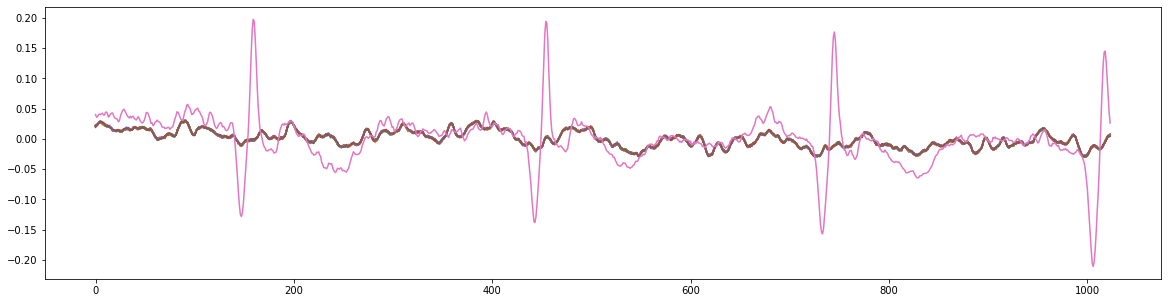

In [50]:
index = 0

if result.shape[2] != 1:
    print( f"Can print")
    plt.figure(figsize=(20,5))
    plt.plot( result[index][:][:] )
    plt.plot( ecg_noisy_24[index])
else:
    print(f"Shape is too large -> {result.shape}")
    